# Linear Regression Implementation from Scratch


Now that you have some background on the *ideas* behind linear regression,
we are ready to step through a hands-on implementation.
In this section, and similar ones that follow,
we are going to implement all parts of linear regression:
the data pipeline, the model, the loss function,
and the gradient descent optimizer, from scratch.
Not surprisingly, today's deep learning frameworks
can automate nearly all of this work,
but if you never learn to implement things from scratch,
then you may never truly understand how the model works.
Moreover, when it comes time to customize models,
defining our own layers, loss functions, etc.,
knowing how things work under the hood will come in handy.
Thus, we start off describing how to implement linear regression
relying only on the primitives in the `torch.Tensor` and `autograd` packages.
In the section immediately following, we will present the compact implementation, using all of torch's bells and whistles,
but this is where we dive into the details.

To start off, we import the packages required to run this section's experiments: we'll be using `matplotlib` for plotting, setting it to embed in the GUI.

In [2]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
import torch
import random

## Generating Data Sets

For this demonstration, we will construct a simple artificial dataset
so that we can easily visualize the data
and compare the true pattern to the learned parameters.
We will set the number of examples in our training set to be 1000
and the number of features (or covariates) to 2.
Thus our synthetic dataset will be an object
$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$.
In this example, we will synthesize our data by sampling
each data point $\mathbf{x}_i$ from a Gaussian distribution.

Moreover, to make sure that our algorithm works,
we will assume that the linearity assumption holds
with true underlying parameters $\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$.
Thus our synthetic labels will be given according to the
following linear model which includes a noise term $\epsilon$ to account for
measurement errors on the features and labels:

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$$

Following standard assumptions, we choose a noise term $\epsilon$
that obeys a normal distribution with mean of $0$,
and in this example, we'll set its standard deviation to $0.01$.
The following code generates our synthetic dataset:

In [3]:
num_inputs = 2
num_examples = 1000
true_w = torch.tensor([2, -3.4])
true_b = 4.2
# features = torch.zeros(size=(num_examples, num_inputs)).normal_()
# labels = torch.matmul(features, true_w) + true_b
# labels += torch.zeros(size=labels.shape).normal_(std=0.01)
# another way
features = torch.randn(size=(num_examples, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.normal(mean=0, std=0.01, size=labels.shape)

Note that each row in `features` consists of a 2-dimensional data point and that each row in `labels` consists of a 1-dimensional target value (a scalar).

In [4]:
features[0], labels[0]

(tensor([-0.1550,  0.3351]), tensor(2.7450))

By generating a scatter plot using the second `features[:, 1]` and `labels`, we can clearly observe the linear correlation between the two.

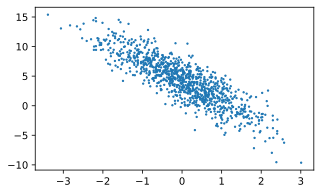

In [9]:
def use_svg_display():
    # Display in vector graphics
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # Set the size of the graph to be plotted
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.figure(figsize=(5, 3))
plt.scatter(features[:, 1].numpy(), labels.numpy(), 2);

The plotting function `plt` as well as the `use_svg_display` and `set_figsize` functions are defined in the `d2l` package. Now that you know how to make plots yourself, we will call `d2l.plt` directly for future plotting. To print the vector diagram and set its size, we only need to call `d2l.set_figsize()` before plotting, because `plt` is a global variable in the `d2l` package.


## Reading Data

Recall that training models, consists of making multiple passes over the dataset, grabbing one mini-batch of examples at a time and using them to update our model. Since this process is so fundamental to training machine learning algortihms, we need a utility for shuffling the data and accessing in mini-batches.

In the following code, we define a `data_iter` function to demonstrate one possible implementation of this functionality.
The function takes a batch size, a design matrix containing the features,
and a vector of labels, yielding minibatches of size `batch_size`,
each consisting of a tuple of features and labels.

In [10]:
# This function has been saved in the d2l package for future use
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        # the index list is a tensor as well
        yield features[j], labels[j]
        # The “take” function will then return the corresponding element based
        # on the indices

In general, note that we want to use reasonably sized minibatches to take advantage of the GPU hardware, which excels at parallelizing operations. Because each example can be fed through our models in parallel and the gradient of the loss function for each example can also be taken in parallel, GPUs allow us to process hundreds of examples in scarcely more time than it might take to process just a single example.

To build some intuition, let's read and print the first small batch of data examples. The shape of the features in each mini-batch tells us both the mini-batch size and the number of input features. Likewise, our mini-batch of labels will have a shape given by `batch_size`.

In [11]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[ 1.5747,  0.2122],
        [ 0.5440,  0.3750],
        [-0.1624, -0.1931],
        [ 0.8611, -1.7433],
        [-0.5896,  1.8591],
        [ 0.8968,  0.2705],
        [ 0.8950, -0.1311],
        [-0.0609,  0.5840],
        [ 1.3566, -1.2712],
        [ 0.5514, -0.5091]]) tensor([ 6.6132,  4.0124,  4.5358, 11.8681, -3.3034,  5.0707,  6.4528,  2.0939,
        11.2391,  7.0325])


It should be no surprise that as we run the iterator,
we will obtain distinct minibatches each time
until all the data has been exhausted (try this).
While the iterator implemented above is good for didactic purposes,
it is inefficient in ways that might get us in trouble on real problems.
For example, it requires that we load all data in memory
and that we perform a lot of random memory access.
<font color=red>The built-in iterators implemented in torch
are considerably efficient and they can deal
both with data stored on file and data fed via a data stream.</font>

## Initialize Model Parameters

Before we can begin optimizing our model's parameters by gradient descent,
we need to have some parameters in the first place.
In the following code, we initialize weights by sampling
random numbers from a normal distribution with mean 0
and a standard deviation of 0.01, setting the bias $b$ to 0.

In [30]:
# w = torch.zeros(size=(num_inputs, 1)).normal_(std=0.01)
w = torch.normal(mean=0, std=0.01, size=(num_inputs, 1))
b = torch.zeros(size=(1,))

Now that we have initialized our parameters,
our next task is to update them until they fit our data sufficiently well.
Each update will require taking the gradient
(a multi-dimensional derivative)
of our loss function with respect to the parameters.
Given this gradient, we will update each parameter
in the direction that reduces the loss.

Since nobody wants to compute gradients explicitly
(this is tedious and error prone),
we use automatic differentiation to compute the gradient.
See :numref:`chapter_autograd`
for more details.
Recall from the autograd chapter
that in order for `autograd` to know
that it should store a gradient for our parameters,
we need to invoke the `attach_grad` function,
allocating memory to store the gradients that we plan to take.

In [31]:
w.requires_grad_(True)
b.requires_grad_(True)

tensor([0.], requires_grad=True)

## Define the Model

Next, we must define our model,
relating its inputs and parameters to its outputs.
Recall that to calculate the output of the linear model,
we simply take the matrix-vector dot product
of the examples $\mathbf{X}$ and the models weights $w$,
and add the offset $b$ to each example.
Note that below `torch.matmul(X, w)` is a vector and `b` is a scalar.
Recall that when we add a vector and a scalar,
the scalar is added to each component of the vector.

In [17]:
# This function has been saved in the d2l package for future use
def linreg(X, w, b):
    return torch.matmul(X, w) + b

## Define the Loss Function

Since updating our model requires taking the gradient of our loss function,
we ought to define the loss function first.
Here we will use the squared loss function
as described in the previous section.
In the implementation, we need to transform the true value `y` into the predicted value's shape `y_hat`.
The result returned by the following function
will also be the same as the `y_hat` shape.

In [18]:
# This function has been saved in the d2l package for future use
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## Define the Optimization Algorithm

As we discussed in the previous section,
linear regression has a closed-form solution.
However, this isn't a book about linear regression,
its a book about deep learning.
Since none of the other models that this book introduces
can be solved analytically, we will take this opportunity to introduce your first working example of stochastic gradient descent (SGD).


At each step, using one batch randomly drawn from our dataset,
we'll estimate the gradient of the loss with respect to our parameters.
Then, we'll update our parameters a small amount
in the direction that reduces the loss.
Assuming that the gradient has already been calculated,
each parameter (`param`) already has its gradient stored in `param.grad`.
The following code applies the SGD update,
given a set of parameters, a learning rate, and a batch size.
The size of the update step is determined by the learning rate `lr`.
Because our loss is calculated as a sum over the batch of examples,
we normalize our step size by the batch size (`batch_size`),
so that the magnitude of a typical step size
doesn't depend heavily on our choice of the batch size.

In [28]:
# This function has been saved in the d2l package for future use
def sgd(params, lr, batch_size):
    for param in params:
        # dta of param subtract lr * gradient / bacth_size
        param.data.sub_(lr*param.grad.data/batch_size)
        # set the gradient of param as zero
        param.grad.data.zero_()

## Training

Now that we have all of the parts in place,
we are ready to implement the main training loop.
It is crucial that you understand this code
because you will see training loops that are nearly identical to this one
over and over again throughout your career in deep learning.

In each iteration, we will grab minibatches of models,
first passing them through our model to obtain a set of predictions.
After calculating the loss, we will call the `backward` function
to backpropagate through the network, storing the gradients
with respect to each parameter in its corresponding `.grad` attribute.
Finally, we will call the optimization algorithm `sgd`
to update the model parameters.
Since we previously set the batch size `batch_size` to 10,
the loss shape `l` for each small batch is (10, 1).

In summary, we'll execute the following loop:

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{\mathcal{B}} \sum_{i \in \mathcal{B}} l(\mathbf{x}^i, y^i, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In the code below, `l` is a vector of the losses
for each example in the minibatch.
Because `l` is not a scalar variable,
running `l.backward()` adds together the elements in `l`
to obtain the new variable and then calculates the gradient.

In each epoch (a pass through the data),
we will iterate through the entire dataset
(using the `data_iter` function) once
passing through every examples in the training dataset
(assuming the number of examples is divisible by the batch size).
The number of epochs `num_epochs` and the learning rate `lr` are both hyper-parameters, which we set here to $3$ and $0.03$, respectively. Unfortunately, setting hyper-parameters is tricky
and requires some adjustment by trial and error.
We elide these details for now but revise them
later in
:numref:`chapter_optimization`.

In [32]:
lr = 0.03  # Learning rate
num_epochs = 3  # Number of iterations
net = linreg  # Our fancy linear model
loss = squared_loss  # 0.5 (y-y')^2

for epoch in range(num_epochs):
    # Assuming the number of examples can be divided by the batch size, all
    # the examples in the training data set are used once in one epoch
    # iteration. The features and tags of mini-batch examples are given by X
    # and y respectively
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in X and y
        l.sum().backward()  # Compute gradient on l with respect to [w,b]
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad(): 
        # otherwise, train_l contains grad information, treated as a Variable
        train_l = loss(net(features, w, b), labels)
        print('epoch %d, loss %f' % (epoch + 1, train_l.mean().numpy()))

epoch 1, loss 0.035984
epoch 2, loss 0.000131
epoch 3, loss 0.000051


In this case, because we used synthetic data (that we synthesized ourselves!),
we know precisely what the true parameters are. Thus, we can evaluate our success in training by comparing the true parameters with those that we learned through our training loop. Indeed they turn out to be very close to each other.

In [33]:
with torch.no_grad():
    # without the code, then grad information is displayed as well
    print('Error in estimating w', true_w - w.reshape(true_w.shape))
    print('Error in estimating b', true_b - b)

Error in estimating w tensor([ 0.0002, -0.0003])
Error in estimating b tensor([0.0007])


Note that we should not take it for granted
that we are able to recover the parameters accurately.
This only happens for a special category problems:
strongly convex optimization problems with 'enough' data to ensure
that the noisy samples allow us to recover the underlying dependency.
In most cases this is *not* the case.
In fact, the parameters of a deep network are rarely the same (or even close) between two different runs, unless all conditions are identical,
including the order in which the data is traversed.
However, in machine learning we are typically less concerned
with recovering true underlying parameters,
and more concerned with parameters that lead to accurate prediction.
Fortunately, even on difficult optimization problems,
that stochastic gradient descent can often lead to remarkably good solutions,
due in part to the fact that for the models we will be working with,
there exist many sets of parameters that work well.

## Summary

We saw how a deep network can be implemented
and optimized from scratch, using just `torch.Tensor` and `autograd`,
without any need for defining layers, fancy optimizers, etc.
This only scratches the surface of what is possible.
In the following sections, we will describe additional models
based on the concepts that we have just introduced
and learn how to implement them more concisely.

## Exercises

1. What would happen if we were to initialize the weights $\mathbf{w} = 0$. Would the algorithm still work?
1. Assume that you're [Georg Simon Ohm](https://en.wikipedia.org/wiki/Georg_Ohm) trying to come up with a model between voltage and current. Can you use `autograd` to learn the parameters of your model.
1. Can you use [Planck's Law](https://en.wikipedia.org/wiki/Planck%27s_law) to determine the temperature of an object using spectral energy density.
1. What are the problems you might encounter if you wanted to extend `autograd` to second derivatives? How would you fix them?
1.  Why is the `reshape` function needed in the `squared_loss` function?
1. Experiment using different learning rates to find out how fast the loss function value drops.
1. If the number of examples cannot be divided by the batch size, what happens to the `data_iter` function's behavior?